# 梯度提升树方法
尝试几种树模型: LGBM, XGBoost, GBDT

In [1]:
# 读取仅经过数据规整的数据. 类别特征进行了Labelencoding, 连续特征未进行处理, 时间特征处理成年龄
import pickle
import pandas as pd
pd.set_option('max_columns', 200)
from utils import submit, evaluation

with open(r'./data/train_T.pkl', 'rb') as f:
    df_train = pickle.load(f)
with open(r'./data/test_T.pkl', 'rb') as f:
    df_test = pickle.load(f)

In [2]:
df_train.head(10)

,id,XINGBIE,HYZK,ZHIYE,ZHICHEN,ZHIWU,XUELI,DWJJLX,DWSSHY,GRZHZT,GRJCJS,GRZHYE,GRZHSNJZYE,GRZHDNGJYE,GRYJCE,DWYJCE,DKFFE,DKYE,DKLL,age,label
0,train_0,1,3,6,3,0,1,9,12,0,1737.0,3223.515,801.310,837.000,312.00,312.00,175237,154112.935,2.708,18,0.0
1,train_1,2,3,6,3,0,1,1,0,0,4894.0,18055.195,53213.220,1065.200,795.84,795.84,300237,298252.945,2.979,34,0.0
2,train_2,1,3,6,3,0,1,9,9,0,10297.0,27426.600,13963.140,7230.020,1444.20,1444.20,150237,147339.130,2.708,27,0.0
3,train_3,1,3,6,3,0,1,9,7,0,10071.5,111871.130,99701.265,2271.295,1417.14,1417.14,350237,300653.780,2.708,37,0.0
4,train_4,2,3,6,3,0,1,27,14,0,2007.0,237.000,11028.875,35.780,325.50,325.50,150237,145185.010,2.708,33,0.0
5,train_5,1,3,6,3,0,1,9,14,0,1192.0,9648.315,7388.550,771.800,303.85,303.85,150237,149743.210,2.708,35,0.0
6,train_6,1,3,6,3,0,1,11,2,0,7297.0,22846.975,12179.565,5885.000,801.80,801.80,150237,146723.725,2.708,33,0.0
7,train_7,1,3,6,3,0,1,9,7,0,1399.0,1808.135,6405.055,1050.400,318.34,318.34,125237,64938.955,2.708,16,0.0
8,train_8,2,3,6,3,0,1,9,9,0,6408.0,79304.635,52365.820,6161.160,977.52,977.52,300237,270579.955,2.979,31,0.0
9,train_9,2,3,6,3,0,1,9,14,0,3573.5,2009.000,61126.175,536.750,637.38,637.38,230237,142296.640,2.708,36,0.0


In [3]:
cate_feat = ['XINGBIE', 'HYZK', 'ZHIYE', 'ZHICHEN', 'XUELI', 'DWJJLX', 'DWSSHY', 'GRZHZT']
all_feat = list(df_train.columns)
all_feat.remove('id')
all_feat.remove('label')
cont_feat = all_feat
for item in cate_feat:
    cont_feat.remove(item)
cont_feat

['ZHIWU',
 'GRJCJS',
 'GRZHYE',
 'GRZHSNJZYE',
 'GRZHDNGJYE',
 'GRYJCE',
 'DWYJCE',
 'DKFFE',
 'DKYE',
 'DKLL',
 'age']

In [4]:
df = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)

In [5]:
df['missing_rate'] = (df.shape[1] - df.count(axis = 1)) / df.shape[1]

df['DKFFE_DKYE'] = df['DKFFE'] + df['DKYE']
df['DKFFE_DKY_multi_DKLL'] = (df['DKFFE'] + df['DKYE']) * df['DKLL']
df['DKFFE_multi_DKLL'] = df['DKFFE'] * df['DKLL']
df['DKYE_multi_DKLL'] = df['DKYE'] * df['DKLL']
df['GRYJCE_DWYJCE'] = df['GRYJCE'] + df['DWYJCE']
df['GRZHDNGJYE_GRZHSNJZYE'] = df['GRZHDNGJYE'] + df['GRZHSNJZYE']

df['DKFFE_multi_DKLL_ratio'] = df['DKFFE'] * df['DKLL'] / df['DKFFE_DKY_multi_DKLL']
df['DKYE_multi_DKLL_ratio'] = df['DKYE'] * df['DKLL'] / df['DKFFE_DKY_multi_DKLL']
df['DKYE_DKFFE_ratio'] = df['DKYE'] / df['DKFFE_DKYE']
df['DKFFE_DKYE_ratio'] = df['DKFFE'] / df['DKFFE_DKYE']
df['GRZHYE_diff_GRZHDNGJYE'] = df['GRZHYE'] - df['GRZHDNGJYE']
df['GRZHYE_diff_GRZHSNJZYE'] = df['GRZHYE'] - df['GRZHSNJZYE']
df['GRYJCE_DWYJCE_ratio'] = df['GRYJCE'] / df['GRYJCE_DWYJCE']
df['DWYJCE_GRYJCE_ratio'] = df['DWYJCE'] / df['GRYJCE_DWYJCE']


gen_feats = ['DKFFE_DKYE', 'DKFFE_DKY_multi_DKLL', 'DKFFE_multi_DKLL', 'DKYE_multi_DKLL', 'GRYJCE_DWYJCE', 
             'GRZHDNGJYE_GRZHSNJZYE', 'DKFFE_multi_DKLL_ratio', 'DKYE_multi_DKLL_ratio', 'GRZHYE_diff_GRZHDNGJYE',
            'GRZHYE_diff_GRZHSNJZYE', 'GRYJCE_DWYJCE_ratio', 'DWYJCE_GRYJCE_ratio', 'DKYE_DKFFE_ratio', 'DKFFE_DKYE_ratio']

<AxesSubplot:xlabel='DKFFE', ylabel='Density'>

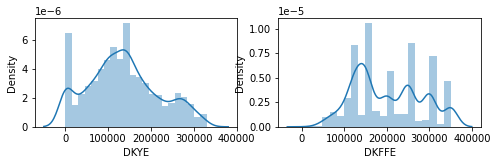

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
def get_daikuanYE(df,col):
    df[col + '_genFeat1'] = (df[col] > 100000).astype(int)
    df[col + '_genFeat2'] = (df[col] > 120000).astype(int)
    df[col + '_genFeat3'] = (df[col] > 140000).astype(int)
    df[col + '_genFeat4'] = (df[col] > 180000).astype(int)
    df[col + '_genFeat5'] = (df[col] > 220000).astype(int)
    df[col + '_genFeat6'] = (df[col] > 260000).astype(int)
    df[col + '_genFeat7'] = (df[col] > 300000).astype(int)
    return df, [col + f'_genFeat{i}' for i in range(1, 8)]

df, genFeats2 = get_daikuanYE(df, col = 'DKYE')
df, genFeats3 = get_daikuanYE(df, col = 'DKFFE')


plt.figure(figsize = (8, 2))
plt.subplot(1,2,1)
sns.distplot(df['DKYE'][df['label'] == 1])
plt.subplot(1,2,2)
sns.distplot(df['DKFFE'][df['label'] == 1])

In [16]:
from tqdm import tqdm

cate_2_cols = ['XINGBIE']
cate_cols = [ 'ZHIYE', 'ZHICHEN', 'DWJJLX', 'DWSSHY', 'GRZHZT']
num_cols = ['GRJCJS', 'GRZHYE', 'GRZHSNJZYE', 'GRZHDNGJYE', 'GRYJCE', 'DWYJCE','DKFFE', 'DKYE', 'DKLL']

for f in tqdm(cate_cols):
    df[f] = df[f].map(dict(zip(df[f].unique(), range(df[f].nunique()))))
    df[f + '_count'] = df[f].map(df[f].value_counts())
    df = pd.concat([df,pd.get_dummies(df[f],prefix=f"{f}")],axis=1)
    
    
cate_cols_combine = [[cate_cols[i], cate_cols[j]] for i in range(len(cate_cols)) \
                     for j in range(i + 1, len(cate_cols))]


for f1, f2 in tqdm(cate_cols_combine):
    df['{}_{}_count'.format(f1, f2)] = df.groupby([f1, f2])['id'].transform('count')
    df['{}_in_{}_prop'.format(f1, f2)] = df['{}_{}_count'.format(f1, f2)] / df[f2 + '_count']
    df['{}_in_{}_prop'.format(f2, f1)] = df['{}_{}_count'.format(f1, f2)] / df[f1 + '_count']

    
for f1 in tqdm(cate_cols):
    g = df.groupby(f1)
    for f2 in num_cols + gen_feats:
        for stat in ['sum', 'mean', 'std', 'max', 'min', 'std']:
            df['{}_{}_{}'.format(f1, f2, stat)] = g[f2].transform(stat)
    for f3 in genFeats2 + genFeats3:
        for stat in ['sum', 'mean']:
            df['{}_{}_{}'.format(f1, f2, stat)] = g[f2].transform(stat)

num_cols_gen_feats = num_cols + gen_feats
for f1 in tqdm(num_cols_gen_feats):
    g = df.groupby(f1)
    for f2 in num_cols_gen_feats:
        if f1 != f2:
            for stat in ['sum', 'mean', 'std', 'max', 'min', 'std']:
                df['{}_{}_{}'.format(f1, f2, stat)] = g[f2].transform(stat)

for i in tqdm(range(len(num_cols_gen_feats))):
    for j in range(i + 1, len(num_cols_gen_feats)):
        df[f'numsOf_{num_cols_gen_feats[i]}_{num_cols_gen_feats[j]}_add'] = df[num_cols_gen_feats[i]] + df[num_cols_gen_feats[j]]
        df[f'numsOf_{num_cols_gen_feats[i]}_{num_cols_gen_feats[j]}_diff'] = df[num_cols_gen_feats[i]] - df[num_cols_gen_feats[j]]
        df[f'numsOf_{num_cols_gen_feats[i]}_{num_cols_gen_feats[j]}_multi'] = df[num_cols_gen_feats[i]] * df[num_cols_gen_feats[j]]
        df[f'numsOf_{num_cols_gen_feats[i]}_{num_cols_gen_feats[j]}_div'] = df[num_cols_gen_feats[i]] / (df[num_cols_gen_feats[j]] + 0.0000000001)
    
            

100%|██████████| 23/23 [00:04<00:00,  4.88it/s]


In [17]:
df = df.T.drop_duplicates().T
train_df = df[df['label'].isna() == False].reset_index(drop=True)
test_df = df[df['label'].isna() == True].reset_index(drop=True)
display(train_df.shape, test_df.shape)

(40000, 3243)

(15000, 3243)

In [21]:
df

,id,XINGBIE,HYZK,ZHIYE,ZHICHEN,ZHIWU,XUELI,DWJJLX,DWSSHY,GRZHZT,GRJCJS,GRZHYE,GRZHSNJZYE,GRZHDNGJYE,GRYJCE,DKFFE,DKYE,DKLL,age,label,missing_rate,DKFFE_DKYE,DKFFE_DKY_multi_DKLL,DKFFE_multi_DKLL,DKYE_multi_DKLL,GRYJCE_DWYJCE,GRZHDNGJYE_GRZHSNJZYE,DKFFE_multi_DKLL_ratio,DKYE_multi_DKLL_ratio,DKYE_DKFFE_ratio,DKFFE_DKYE_ratio,GRZHYE_diff_GRZHDNGJYE,GRZHYE_diff_GRZHSNJZYE,GRYJCE_DWYJCE_ratio,DKYE_genFeat1,DKYE_genFeat2,DKYE_genFeat3,DKYE_genFeat4,DKYE_genFeat5,DKYE_genFeat6,DKYE_genFeat7,DKFFE_genFeat1,DKFFE_genFeat2,DKFFE_genFeat3,DKFFE_genFeat4,DKFFE_genFeat5,DKFFE_genFeat6,DKFFE_genFeat7,ZHIYE_count,ZHIYE_0,ZHIYE_1,ZHIYE_2,ZHIYE_3,ZHIYE_4,ZHIYE_5,ZHIYE_6,ZHICHEN_count,ZHICHEN_0,ZHICHEN_1,ZHICHEN_2,DWJJLX_count,DWJJLX_0,DWJJLX_1,DWJJLX_2,DWJJLX_3,DWJJLX_4,DWJJLX_5,DWJJLX_6,DWJJLX_7,DWJJLX_8,DWJJLX_9,DWJJLX_10,DWJJLX_11,DWJJLX_12,DWJJLX_13,DWJJLX_14,DWJJLX_15,DWJJLX_16,DWJJLX_17,DWJJLX_18,DWJJLX_19,DWJJLX_20,DWJJLX_21,DWJJLX_22,DWJJLX_23,DWJJLX_24,DWJJLX_25,DWJJLX_26,DWJJLX_27,DWSSHY_count,DWSSHY_0,DWSSHY_1,DWSSHY_2,DWSSHY_3,DWSSHY_4,DWSSHY_5,DWSSHY_6,DWSSHY_7,DWSSHY_8,DWSSHY_9,...,numsOf_GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE_div,numsOf_GRZHDNGJYE_GRZHSNJZYE_GRYJCE_DWYJCE_ratio_add,numsOf_GRZHDNGJYE_GRZHSNJZYE_GRYJCE_DWYJCE_ratio_diff,numsOf_GRZHDNGJYE_GRZHSNJZYE_GRYJCE_DWYJCE_ratio_multi,numsOf_GRZHDNGJYE_GRZHSNJZYE_GRYJCE_DWYJCE_ratio_div,numsOf_GRZHDNGJYE_GRZHSNJZYE_DKYE_DKFFE_ratio_add,numsOf_GRZHDNGJYE_GRZHSNJZYE_DKYE_DKFFE_ratio_diff,numsOf_GRZHDNGJYE_GRZHSNJZYE_DKYE_DKFFE_ratio_multi,numsOf_GRZHDNGJYE_GRZHSNJZYE_DKYE_DKFFE_ratio_div,numsOf_GRZHDNGJYE_GRZHSNJZYE_DKFFE_DKYE_ratio_add,numsOf_GRZHDNGJYE_GRZHSNJZYE_DKFFE_DKYE_ratio_diff,numsOf_GRZHDNGJYE_GRZHSNJZYE_DKFFE_DKYE_ratio_multi,numsOf_GRZHDNGJYE_GRZHSNJZYE_DKFFE_DKYE_ratio_div,numsOf_DKFFE_multi_DKLL_ratio_DKYE_multi_DKLL_ratio_add,numsOf_DKFFE_multi_DKLL_ratio_DKYE_multi_DKLL_ratio_diff,numsOf_DKFFE_multi_DKLL_ratio_DKYE_multi_DKLL_ratio_multi,numsOf_DKFFE_multi_DKLL_ratio_DKYE_multi_DKLL_ratio_div,numsOf_DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_add,numsOf_DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_diff,numsOf_DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_multi,numsOf_DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_div,numsOf_DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_add,numsOf_DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_diff,numsOf_DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_multi,numsOf_DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_div,numsOf_DKFFE_multi_DKLL_ratio_GRYJCE_DWYJCE_ratio_add,numsOf_DKFFE_multi_DKLL_ratio_GRYJCE_DWYJCE_ratio_diff,numsOf_DKFFE_multi_DKLL_ratio_GRYJCE_DWYJCE_ratio_multi,numsOf_DKFFE_multi_DKLL_ratio_GRYJCE_DWYJCE_ratio_div,numsOf_DKFFE_multi_DKLL_ratio_DKYE_DKFFE_ratio_add,numsOf_DKFFE_multi_DKLL_ratio_DKYE_DKFFE_ratio_diff,numsOf_DKFFE_multi_DKLL_ratio_DKYE_DKFFE_ratio_multi,numsOf_DKFFE_multi_DKLL_ratio_DKYE_DKFFE_ratio_div,numsOf_DKFFE_multi_DKLL_ratio_DKFFE_DKYE_ratio_add,numsOf_DKFFE_multi_DKLL_ratio_DKFFE_DKYE_ratio_diff,numsOf_DKFFE_multi_DKLL_ratio_DKFFE_DKYE_ratio_multi,numsOf_DKFFE_multi_DKLL_ratio_DKFFE_DKYE_ratio_div,numsOf_DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_add,numsOf_DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_diff,numsOf_DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_multi,numsOf_DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_div,numsOf_DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_add,numsOf_DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_diff,numsOf_DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_multi,numsOf_DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_div,numsOf_DKYE_multi_DKLL_ratio_GRYJCE_DWYJCE_ratio_add,numsOf_DKYE_multi_DKLL_ratio_GRYJCE_DWYJCE_ratio_diff,numsOf_DKYE_multi_DKLL_ratio_GRYJCE_DWYJCE_ratio_multi,numsOf_DKYE_multi_DKLL_ratio_GRYJCE_DWYJCE_ratio_div,numsOf_DKYE_multi_DKLL_ratio_DKYE_DKFFE_ratio_add,numsOf_DKYE_multi_DKLL_ratio_DKYE_DKFFE_ratio_diff,numsOf_DKYE_multi_DKLL_ratio_DKYE_DKFFE_ratio_multi,numsOf_DKYE_multi_DKLL_ratio_DKYE_DKFFE_ratio_div,numsOf_DKYE_multi_DKLL_ratio_DKF

In [22]:
df = df.drop(['id'], axis=1).astype('float')
drop_feats = [f for f in train_df.columns if train_df[f].nunique() == 1 or train_df[f].nunique() == 0]
len(drop_feats), drop_feats

(114,
 ['missing_rate',
  'GRYJCE_DWYJCE_ratio',
  'ZHIYE_GRYJCE_DWYJCE_ratio_std',
  'ZHICHEN_GRYJCE_DWYJCE_ratio_std',
  'DWSSHY_DKYE_min',
  'GRJCJS_GRYJCE_DWYJCE_ratio_std',
  'GRZHYE_GRYJCE_DWYJCE_ratio_std',
  'GRZHSNJZYE_GRYJCE_DWYJCE_ratio_std',
  'GRZHDNGJYE_GRYJCE_DWYJCE_ratio_std',
  'GRYJCE_DWYJCE_std',
  'DKFFE_GRYJCE_DWYJCE_ratio_std',
  'DKYE_GRYJCE_DWYJCE_ratio_std',
  'DKLL_GRYJCE_DWYJCE_ratio_std',
  'DKFFE_DKYE_GRYJCE_DWYJCE_ratio_std',
  'DKFFE_DKY_multi_DKLL_DKLL_std',
  'DKFFE_multi_DKLL_DKFFE_std',
  'DKYE_multi_DKLL_DKYE_std',
  'GRZHDNGJYE_GRZHSNJZYE_GRYJCE_DWYJCE_ratio_std',
  'DKFFE_multi_DKLL_ratio_GRYJCE_DWYJCE_ratio_std',
  'DKYE_multi_DKLL_ratio_GRYJCE_DWYJCE_ratio_std',
  'GRZHYE_diff_GRZHDNGJYE_GRYJCE_DWYJCE_ratio_std',
  'GRZHYE_diff_GRZHSNJZYE_GRYJCE_DWYJCE_ratio_std',
  'GRYJCE_DWYJCE_ratio_GRJCJS_sum',
  'GRYJCE_DWYJCE_ratio_GRJCJS_mean',
  'GRYJCE_DWYJCE_ratio_GRJCJS_std',
  'GRYJCE_DWYJCE_ratio_GRJCJS_max',
  'GRYJCE_DWYJCE_ratio_GRJCJS_min',
  'G

In [23]:
df.head(-10)

,XINGBIE,HYZK,ZHIYE,ZHICHEN,ZHIWU,XUELI,DWJJLX,DWSSHY,GRZHZT,GRJCJS,GRZHYE,GRZHSNJZYE,GRZHDNGJYE,GRYJCE,DKFFE,DKYE,DKLL,age,label,missing_rate,DKFFE_DKYE,DKFFE_DKY_multi_DKLL,DKFFE_multi_DKLL,DKYE_multi_DKLL,GRYJCE_DWYJCE,GRZHDNGJYE_GRZHSNJZYE,DKFFE_multi_DKLL_ratio,DKYE_multi_DKLL_ratio,DKYE_DKFFE_ratio,DKFFE_DKYE_ratio,GRZHYE_diff_GRZHDNGJYE,GRZHYE_diff_GRZHSNJZYE,GRYJCE_DWYJCE_ratio,DKYE_genFeat1,DKYE_genFeat2,DKYE_genFeat3,DKYE_genFeat4,DKYE_genFeat5,DKYE_genFeat6,DKYE_genFeat7,DKFFE_genFeat1,DKFFE_genFeat2,DKFFE_genFeat3,DKFFE_genFeat4,DKFFE_genFeat5,DKFFE_genFeat6,DKFFE_genFeat7,ZHIYE_count,ZHIYE_0,ZHIYE_1,ZHIYE_2,ZHIYE_3,ZHIYE_4,ZHIYE_5,ZHIYE_6,ZHICHEN_count,ZHICHEN_0,ZHICHEN_1,ZHICHEN_2,DWJJLX_count,DWJJLX_0,DWJJLX_1,DWJJLX_2,DWJJLX_3,DWJJLX_4,DWJJLX_5,DWJJLX_6,DWJJLX_7,DWJJLX_8,DWJJLX_9,DWJJLX_10,DWJJLX_11,DWJJLX_12,DWJJLX_13,DWJJLX_14,DWJJLX_15,DWJJLX_16,DWJJLX_17,DWJJLX_18,DWJJLX_19,DWJJLX_20,DWJJLX_21,DWJJLX_22,DWJJLX_23,DWJJLX_24,DWJJLX_25,DWJJLX_26,DWJJLX_27,DWSSHY_count,DWSSHY_0,DWSSHY_1,DWSSHY_2,DWSSHY_3,DWSSHY_4,DWSSHY_5,DWSSHY_6,DWSSHY_7,DWSSHY_8,DWSSHY_9,DWSSHY_10,...,numsOf_GRZHDNGJYE_GRZHSNJZYE_GRZHYE_diff_GRZHSNJZYE_div,numsOf_GRZHDNGJYE_GRZHSNJZYE_GRYJCE_DWYJCE_ratio_add,numsOf_GRZHDNGJYE_GRZHSNJZYE_GRYJCE_DWYJCE_ratio_diff,numsOf_GRZHDNGJYE_GRZHSNJZYE_GRYJCE_DWYJCE_ratio_multi,numsOf_GRZHDNGJYE_GRZHSNJZYE_GRYJCE_DWYJCE_ratio_div,numsOf_GRZHDNGJYE_GRZHSNJZYE_DKYE_DKFFE_ratio_add,numsOf_GRZHDNGJYE_GRZHSNJZYE_DKYE_DKFFE_ratio_diff,numsOf_GRZHDNGJYE_GRZHSNJZYE_DKYE_DKFFE_ratio_multi,numsOf_GRZHDNGJYE_GRZHSNJZYE_DKYE_DKFFE_ratio_div,numsOf_GRZHDNGJYE_GRZHSNJZYE_DKFFE_DKYE_ratio_add,numsOf_GRZHDNGJYE_GRZHSNJZYE_DKFFE_DKYE_ratio_diff,numsOf_GRZHDNGJYE_GRZHSNJZYE_DKFFE_DKYE_ratio_multi,numsOf_GRZHDNGJYE_GRZHSNJZYE_DKFFE_DKYE_ratio_div,numsOf_DKFFE_multi_DKLL_ratio_DKYE_multi_DKLL_ratio_add,numsOf_DKFFE_multi_DKLL_ratio_DKYE_multi_DKLL_ratio_diff,numsOf_DKFFE_multi_DKLL_ratio_DKYE_multi_DKLL_ratio_multi,numsOf_DKFFE_multi_DKLL_ratio_DKYE_multi_DKLL_ratio_div,numsOf_DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_add,numsOf_DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_diff,numsOf_DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_multi,numsOf_DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_div,numsOf_DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_add,numsOf_DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_diff,numsOf_DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_multi,numsOf_DKFFE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_div,numsOf_DKFFE_multi_DKLL_ratio_GRYJCE_DWYJCE_ratio_add,numsOf_DKFFE_multi_DKLL_ratio_GRYJCE_DWYJCE_ratio_diff,numsOf_DKFFE_multi_DKLL_ratio_GRYJCE_DWYJCE_ratio_multi,numsOf_DKFFE_multi_DKLL_ratio_GRYJCE_DWYJCE_ratio_div,numsOf_DKFFE_multi_DKLL_ratio_DKYE_DKFFE_ratio_add,numsOf_DKFFE_multi_DKLL_ratio_DKYE_DKFFE_ratio_diff,numsOf_DKFFE_multi_DKLL_ratio_DKYE_DKFFE_ratio_multi,numsOf_DKFFE_multi_DKLL_ratio_DKYE_DKFFE_ratio_div,numsOf_DKFFE_multi_DKLL_ratio_DKFFE_DKYE_ratio_add,numsOf_DKFFE_multi_DKLL_ratio_DKFFE_DKYE_ratio_diff,numsOf_DKFFE_multi_DKLL_ratio_DKFFE_DKYE_ratio_multi,numsOf_DKFFE_multi_DKLL_ratio_DKFFE_DKYE_ratio_div,numsOf_DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_add,numsOf_DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_diff,numsOf_DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_multi,numsOf_DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHDNGJYE_div,numsOf_DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_add,numsOf_DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_diff,numsOf_DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_multi,numsOf_DKYE_multi_DKLL_ratio_GRZHYE_diff_GRZHSNJZYE_div,numsOf_DKYE_multi_DKLL_ratio_GRYJCE_DWYJCE_ratio_add,numsOf_DKYE_multi_DKLL_ratio_GRYJCE_DWYJCE_ratio_diff,numsOf_DKYE_multi_DKLL_ratio_GRYJCE_DWYJCE_ratio_multi,numsOf_DKYE_multi_DKLL_ratio_GRYJCE_DWYJCE_ratio_div,numsOf_DKYE_multi_DKLL_ratio_DKYE_DKFFE_ratio_add,numsOf_DKYE_multi_DKLL_ratio_DKYE_DKFFE_ratio_diff,numsOf_DKYE_multi_DKLL_ratio_DKYE_DKFFE_ratio_multi,numsOf_DKYE_multi_DKLL_ratio_DKYE_DKFFE_ratio_div,numsOf_DKYE_multi_DKLL_ra

In [25]:
# 构建特征和标签
y_train = train_df['label']
X_train = train_df.drop(['id', 'label', 'HYZK', 'ZHIWU', 'XUELI'], axis=1)
X_test = test_df.drop(['id', 'HYZK', 'ZHIWU', 'XUELI'], axis=1)

In [22]:
df['HYZK_1']

,HYZK_1,HYZK_1
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
54995,0,0
54996,0,0
54997,0,0
54998,0,0


In [28]:
cols = [col for col in train_df.columns if col not in ['id', 'label'] + drop_feats]
cols.remove('HYZK')
cols.remove('ZHIWU')
cols.remove('XUELI')
X_train = X_train[cols].astype('float')
X_test = X_test[cols].astype('float')

In [29]:
y_train = y_train.astype('int')

# 使用LGBM进行建模
特征就使用最原始的特征. 训练和验证方式K-折交叉验证

In [39]:
import lightgbm as lgb
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

KF = StratifiedKFold(n_splits=5)
params = {
    'verbose':-1, 
    'objective':'binary',
    'metric':'auc',
    'num_iterations': 10000, 
    'is_unbalance': True,
}


oof_lgb = np.zeros(len(X_train))
predictions_lgb = np.zeros((len(X_test)))

cate_feat = ['XINGBIE', 'ZHIYE', 'ZHICHEN', 'DWJJLX', 'DWSSHY', 'GRZHZT']

for fold_, (trn_idx, val_idx) in enumerate(KF.split(X_train.values, y_train.values)):
    print("fold n°{}".format(fold_))
    print('trn_idx:',trn_idx)
    print('val_idx:',val_idx)
    trn_data = lgb.Dataset(X_train.iloc[trn_idx],label=y_train.iloc[trn_idx])    
    val_data = lgb.Dataset(X_train.iloc[val_idx],label=y_train.iloc[val_idx])
    num_round = 10000
    clf = lgb.train(
        params,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds=200,  
        categorical_feature=cate_feat
    )
        
    oof_lgb[val_idx] = clf.predict(X_train.iloc[val_idx], num_iteration=clf.best_iteration)
    predictions_lgb[:] += clf.predict(X_test, num_iteration=clf.best_iteration) 
print("AUC score: {}".format(roc_auc_score(y_train, oof_lgb)))
print("TPR weight: {}".format(evaluation(y_train, oof_lgb)))

fold n°0
trn_idx: [ 7984  7985  7986 ... 39997 39998 39999]
val_idx: [   0    1    2 ... 8249 8282 8288]
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[61]	training's auc: 0.991819	valid_1's auc: 0.944485
fold n°1
trn_idx: [    0     1     2 ... 39997 39998 39999]
val_idx: [ 7984  7985  7986 ... 15997 15998 15999]
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[77]	training's auc: 0.994418	valid_1's auc: 0.948272
fold n°2
trn_idx: [    0     1     2 ... 39997 39998 39999]
val_idx: [16000 16001 16002 ... 24382 24393 24455]
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[137]	training's auc: 0.999194	valid_1's auc: 0.935285
fold n°3
trn_idx: [    0     1     2 ... 39997 39998 39999]
val_idx: [23964 23965 23966 ... 32011 32014 32019]
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 1	valid_1's auc: 0.94040

In [40]:
# 对测试集进行预测, 并得到提交文件
res = predictions_lgb / 5
submit(res)

In [41]:
predictions_lgb.shape

(15000,)